# Importing

In [2]:
# Data wrangling
import numpy as np
import pandas as pd  # Not a requirement of giotto-tda, but is compatible with the gtda.mapper module
import os
import time
import itertools
import open3d as o3d

# Data viz
from gtda.plotting import plot_point_cloud
from gtda.plotting import plot_diagram

# TDA magic
from gtda.homology import VietorisRipsPersistence
from gtda.mapper import (
    CubicalCover,
    make_mapper_pipeline,
    Projection,
    plot_static_mapper_graph,
    plot_interactive_mapper_graph,
    MapperInteractivePlotter
)

# ML tools
from sklearn import datasets
from sklearn.cluster import DBSCAN
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn import svm
from src.feature_vectors import create_feature_vector

from sklearn.model_selection import cross_val_score

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


# Prepare cloud points

In [3]:
def get_ply_files(folder):
    files = list(filter(lambda file: file.split('.')[-1]=='ply', os.listdir(folder)))
    files = list(map(lambda file: os.path.join(folder, file),files))
    return files

ply_files  = get_ply_files('data/tablesPly')
ply_files += get_ply_files('data/chairsPly')
ply_files += get_ply_files('data/octopusPly')
ply_files += get_ply_files('data/spidersPly')

# if (k == None) label each group differently 
# else label files in group k with True and others with False
def label_groups(files, k):
    group_sizes = [len([f for f in os.listdir('data/'+file) if f[-3:]=='ply']) for file in files]
    group_sizes = [sum(group_sizes[:k]), group_sizes[k], sum(group_sizes[k+1:])]
    # print(group_sizes)
    labels = np.zeros(sum(group_sizes))
    labels[group_sizes[0]:group_sizes[0]+group_sizes[1]] = 1
        
    return labels
    
files = ['tablesPly','chairsPly', 'octopusPly', 'spidersPly']
labels = label_groups(files, 3)
majority_classifier = (1 - sum(labels)/len(labels))
print("Majority class classifier accuracy: %.3f" % majority_classifier)

pcd = [o3d.io.read_point_cloud(file) for file in ply_files]
pcd = [np.asarray(pc.points) for pc in pcd]

Majority class classifier accuracy: 0.693


In [4]:
# shuffle data for more accurate results
shuffle_index = np.random.permutation(np.arange(0, len(labels)))
labels = np.array(labels)
pcd = np.array(pcd, dtype=object)
labels = labels[shuffle_index]
pcd = pcd[shuffle_index]

## Persistance and pipe

In [5]:
# Track connected components, loops, and voids
homology_dimensions = [0, 1, 2]

# Collapse edges to speed up H2 persistence calculation!
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)

#filter_func = Projection(columns=[0,1,2])
filter_func = PCA(n_components=2)

cover = CubicalCover(n_intervals=4, overlap_frac=0.08)
#cover = OneDimensionalCover(kind='uniform', n_intervals=10, overlap_frac=0.1)

clusterer = DBSCAN(eps=10, metric="chebyshev")

n_jobs = 1

pipe = make_mapper_pipeline(
    filter_func=filter_func,
    cover=cover,
    clusterer=clusterer,
    verbose=False,
    n_jobs=n_jobs,
)

# Feature vector creation

In [6]:
entropy_feature_vectors = []
feature_vectors = []
start = time.time()
for i, pc in enumerate(pcd):
    print('\r', f"{int((i/len(pcd))*100)}%", end="")
    e_fv, fv = create_feature_vector(pc, pipe, persistence)

    entropy_feature_vectors.append(e_fv)
    feature_vectors.append(fv)
end = time.time()
print("Time to compute create feature vectors:", end - start, "s")

 99%Time to compute create feature vectors: 103.6719605922699 s


In [7]:
len(pcd), feature_vectors

(101,
 [[2, 3.1666666666666665, 0.28787878787878785, 0.2833333333333333],
  [5, 3.75, 0.25, 0.44732142857142854],
  [6, 3.375, 0.225, 0.30089285714285713],
  [8, 2.375, 0.15833333333333333, 0.075],
  [2, 3.875, 0.25833333333333336, 0.42857142857142855],
  [4, 3.375, 0.225, 0.41607142857142854],
  [0, 5.25, 0.35, 0.657142857142857],
  [2, 3.125, 0.20833333333333334, 0.25],
  [0, 5.25, 0.35, 0.657142857142857],
  [3, 3.5714285714285716, 0.27472527472527475, 0.6096938775510203],
  [5, 3.6470588235294117, 0.22794117647058823, 0.5676470588235294],
  [7, 3.238095238095238, 0.1619047619047619, 0.45986394557823135],
  [2, 3.375, 0.225, 0.22499999999999998],
  [4, 4.105263157894737, 0.2280701754385965, 0.6429824561403509],
  [4, 3.125, 0.20833333333333334, 0.25],
  [2, 4.888888888888889, 0.28758169934640526, 0.5285714285714286],
  [8, 3.3333333333333335, 0.16666666666666669, 0.4765306122448979],
  [12, 1.875, 0.125, 0.0],
  [6, 3.739130434782609, 0.1699604743083004, 0.7017598343685301],
  [2, 3

## With homologies

In [58]:
num_features = len(feature_vectors[0])
clf = svm.SVC(kernel='linear', C=1, random_state=42)
best_scores = []
# We take one homology and up to three other features

for homology_idx in range(3):
    final_fvs = []
    
    # First add homology and nothing else
    for entropy_fv in entropy_feature_vectors:
        final_fvs.append(entropy_fv[homology_idx])

    # TODO add train and test
    scores = cross_val_score(clf, final_fvs, labels, cv=10)
    y_pred = cross_val_predict(clf, final_fvs, labels, cv=10)
    conf_mat = confusion_matrix(labels, y_pred)
    best_scores.append((scores.mean(), "h"+str(homology_idx+1), conf_mat))
    print("%0.2f accuracy with a standard deviation of %0.2f  %s" % (scores.mean(), scores.std(), "Homology"+str(homology_idx+1)))

    for number_of_additional_features in range(1,4):
        combinations = list(itertools.combinations(range(num_features), number_of_additional_features))

        # Loop through all posible feature subsets of size
        for combination in combinations:
            # print(combination)
            final_fvs = []
            # First add homology and a certain number of features
            for fv_idx, entropy_fv in enumerate(entropy_feature_vectors):
                extracted_fv = [x for x in entropy_fv[homology_idx]]

                extracted_fv += [feature_vectors[fv_idx][i] for i in combination]

                final_fvs.append(extracted_fv)

            # TODO add train and test
            scores = cross_val_score(clf, final_fvs, labels, cv=10)
            y_pred = cross_val_predict(clf, final_fvs, labels, cv=10)
            conf_mat = confusion_matrix(labels, y_pred)
            best_scores.append((scores.mean(), ''.join([str(x)+" " for x in combination]) + "h" + str(homology_idx+1), conf_mat))
            print("%0.2f accuracy with a standard deviation of %0.2f  %s" % (scores.mean(), scores.std(), "Combination of features "+str(combination)))

            # print(final_fvs)
            
best_scores.sort(reverse=True)
print("\nAverage score: %0.4f" % (sum([x for x, s, cm in best_scores]) / len(best_scores)))
print("Best scores:", [x[:2] for x in best_scores[:3]])

0.69 accuracy with a standard deviation of 0.02  Homology1
0.69 accuracy with a standard deviation of 0.02  Combination of features (0,)
0.69 accuracy with a standard deviation of 0.02  Combination of features (1,)
0.69 accuracy with a standard deviation of 0.02  Combination of features (2,)
0.69 accuracy with a standard deviation of 0.02  Combination of features (3,)
0.69 accuracy with a standard deviation of 0.02  Combination of features (0, 1)
0.69 accuracy with a standard deviation of 0.02  Combination of features (0, 2)
0.69 accuracy with a standard deviation of 0.02  Combination of features (0, 3)
0.69 accuracy with a standard deviation of 0.02  Combination of features (1, 2)
0.69 accuracy with a standard deviation of 0.02  Combination of features (1, 3)
0.69 accuracy with a standard deviation of 0.02  Combination of features (2, 3)
0.69 accuracy with a standard deviation of 0.02  Combination of features (0, 1, 2)
0.69 accuracy with a standard deviation of 0.02  Combination of fe

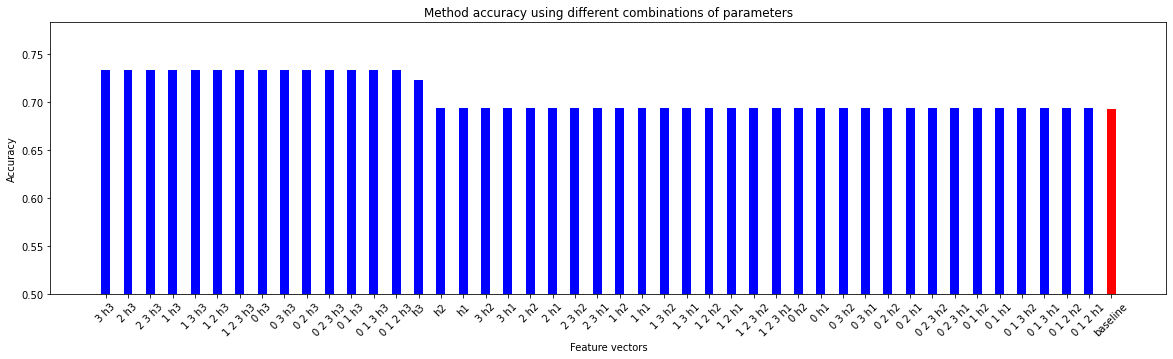

In [60]:
import numpy as np
import matplotlib.pyplot as plt

data = [(score, comb) for score, comb, cm in best_scores if score >= majority_classifier]
fig = plt.figure(figsize = (20, 5))
plt.bar([x[1] for x in data], [x[0] for x in data], color ='blue', width = 0.4)
plt.bar("baseline", majority_classifier, color ='red', width = 0.4)
plt.ylim(0.5, best_scores[0][0] + 0.05)
plt.xticks(rotation = 45)
plt.xlabel("Feature vectors")
plt.ylabel("Accuracy")
plt.title("Method accuracy using different combinations of parameters")
plt.show()

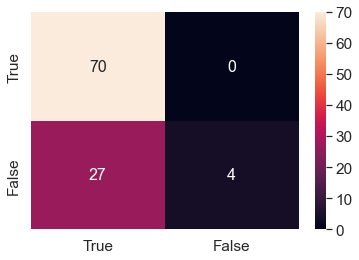

In [67]:
import seaborn as sn

df_cm = pd.DataFrame(best_scores[0][2], index = ['True','False'], columns = ['True','False'])
sn.set(font_scale=1.4) # for label size
sn.heatmap(df_cm, annot=True, annot_kws={"size": 16}) # font size
plt.show()

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(final_fvs, labels, test_size=0.33, random_state=42)

SVM = svm.LinearSVC()
SVM.fit(X_train, y_train)
SVM.predict(X_test)
round(SVM.score(X_test,y_test), 4)

## Without homologies

In [30]:
for number_of_additional_features in range(1,6):
    combinations = list(itertools.combinations(range(num_features), number_of_additional_features))

    # Loop through all posible feature subsets of size
    for combination in combinations:
        # print(combination)
        final_fvs = []
        # First add homology and a certain number of features
        for fv_idx, fv in enumerate(feature_vectors):
            extracted_fv = [fv[i] for i in combination]

            final_fvs.append(extracted_fv)

        # TODO add train and test
        scores = cross_val_score(clf, final_fvs, labels, cv=10)
        best_scores.append((scores.mean(), str(combination) + " " + str(homology_idx)))
        print("%0.2f accuracy with a standard deviation of %0.2f  %s" % (scores.mean(), scores.std(), "Combination of features "+str(combination)))

        # print(final_fvs)


0.69 accuracy with a standard deviation of 0.02  Combination of features (0,)
0.69 accuracy with a standard deviation of 0.02  Combination of features (1,)
0.69 accuracy with a standard deviation of 0.02  Combination of features (2,)
0.69 accuracy with a standard deviation of 0.02  Combination of features (3,)
0.69 accuracy with a standard deviation of 0.02  Combination of features (0, 1)
0.69 accuracy with a standard deviation of 0.02  Combination of features (0, 2)
0.69 accuracy with a standard deviation of 0.02  Combination of features (0, 3)
0.69 accuracy with a standard deviation of 0.02  Combination of features (1, 2)
0.69 accuracy with a standard deviation of 0.02  Combination of features (1, 3)
0.69 accuracy with a standard deviation of 0.02  Combination of features (2, 3)
0.69 accuracy with a standard deviation of 0.02  Combination of features (0, 1, 2)
0.69 accuracy with a standard deviation of 0.02  Combination of features (0, 1, 3)
0.69 accuracy with a standard deviation of

In [31]:
X_train, X_test, y_train, y_test = train_test_split(final_fvs, labels, test_size=0.33, random_state=42)

SVM = svm.LinearSVC()
SVM.fit(X_train, y_train)
SVM.predict(X_test)
round(SVM.score(X_test,y_test), 4)

c:\users\marija\appdata\local\programs\python\python38\lib\site-packages\sklearn\svm\_base.py:1206: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



0.5882